In [2]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import utils as myutils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [19]:
FLAG_force_binary = 1
FLAG_target = 'management'

In [20]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [51]:
data_dir = "/data/put_data/cmchang/gynecology/data/"
d = pd.read_csv(os.path.join(data_dir, 'data_merged.csv'))
d = d[myutils.get_n_zeros(np.array(d[[k for k in d.columns if 'b-' in k]], dtype=np.float)) <= 200]

In [52]:
if FLAG_force_binary : 
    d[d[FLAG_target]>1] = 1

In [53]:
one_hot_column = ['variability', 'UA', 'deceleration']
numeric_column = ['FHB', 'UA_duration', 'UA_interval', 'seconds']

In [54]:
one_hot_df = pd.DataFrame()
for tg in one_hot_column:
    tmp_dm = pd.get_dummies(d[tg])
    tmp_dm.columns = [tg+'_'+str(i) for i in range(tmp_dm.shape[1])]
    one_hot_df = pd.concat([one_hot_df, tmp_dm], axis=1)

In [55]:
X = pd.concat([one_hot_df, d.loc[:,numeric_column]], axis=1)

In [56]:
Y = d.loc[:, 'management']

In [57]:
n_classes = len(set(Y))

In [58]:
data_dmatrix = xgb.DMatrix(data=X,label=Y)

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=13, stratify = Y)

In [60]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]
xgb_clsfy = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
xgb_clsfy.fit(X_train, Y_train, eval_metric=["error", "logloss"],
              eval_set=eval_set, verbose=False)

preds = xgb_clsfy.predict(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[38  2]
 [ 2 20]]
[[38  2]
 [ 2 20]]
recall-0 : 0.95
recall-1 : 0.9090909090909091
accu=0.9354838709677419


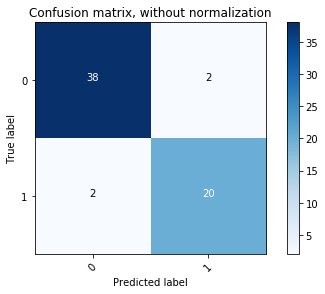

In [61]:
cfm = confusion_matrix(y_pred=preds, y_true=Y_test)
recall = np.diag(cfm) / np.sum(cfm, axis=1)
precision = np.diag(cfm) / np.sum(cfm, axis=0)
val_accu = accuracy_score(y_pred=preds, y_true=Y_test)

myutils.plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='Confusion matrix, without normalization')
print(cfm)
for i in range(n_classes):
    print('recall-{0} : {1}'.format(i, recall[i]))
    #sav['precision-{0}'.format(i)] = precision[i]
print('accu={0}'.format(val_accu))

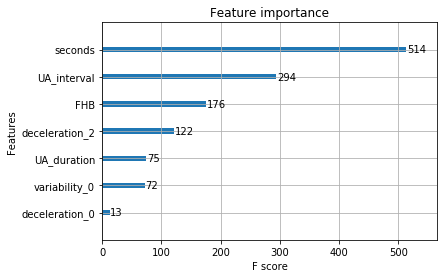

In [62]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgb_clsfy)
pyplot.show()

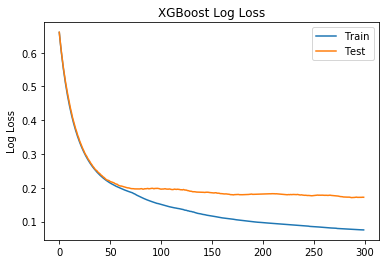

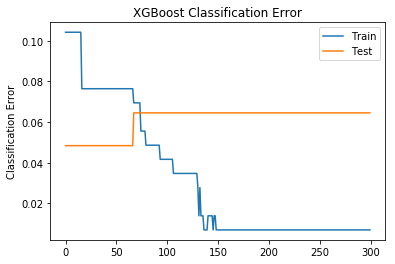

In [63]:

results = xgb_clsfy.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [42]:
# os.environ["PATH"] += os.pathsep + '/usr/local/lib/python3.5/dist-packages/graphviz/'
# from xgboost import plot_tree

# fig, ax = plt.subplots(figsize=(10, 10))
# xgb.plot_tree(xgb_clsfy, num_trees=4, ax=ax)

# plt.show()